# Software Information Entropy

In [2]:
import math
import pathlib
import shutil
import tempfile
from concurrent.futures import ProcessPoolExecutor, as_completed

import git
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# read example data which includes pubmed github links detected from article abstracts
pd.read_parquet("../../../tests/data/examples/pubmed/pubmed_github_links.parquet")

,PMID,article_date,title,authors,github_link,IsValid
0,29409532,2018-02-06,SCANPY: large-scale single-cell gene expressio...,"Wolf, Angerer, Theis",https://github.com/theislab/Scanpy,True
1,29409532,2018-02-06,SCANPY: large-scale single-cell gene expressio...,"Wolf, Angerer, Theis",https://github.com/theislab/anndata,True
2,35814290,2022-03-28,WormBase single-cell tools.,"da Veiga Beltrame, Arnaboldi, Sternberg",https://github.com/WormBase/scdefg,True
3,35814290,2022-03-28,WormBase single-cell tools.,"da Veiga Beltrame, Arnaboldi, Sternberg",https://github.com/WormBase/wormcells-viz,True
4,37096789,None,Beginner's Guide on the Use of PAML to Detect ...,"Álvarez-Carretero, Kapli, Yang",https://github.com/abacus-gene/paml,True
...,...,...,...,...,...,...
10234,37387130,None,SpatialSort: a Bayesian model for clustering a...,"Lee, Chern, Nissen, Wang, , Huang, Gandhi, Bou...",https://github.com/Roth-Lab/SpatialSort,True
10235,37382572,None,Robust joint clustering of multi-omics single-...,"Jiang, Zhan, Ching, Chen",https://github.com/jianghruc/scHoML,True
10236,37369035,None,Hierarchical graph transformer with contrastiv...,"Gu, Luo, Chen, Deng, Lai",https://github.com/ZhonghuiGu/HEAL,True
10237,37359539,2023-06-08,Trapalyzer: a computer program for quantitativ...,"Ciach, Bokota, Manda-Handzlik, Kuźmicka, Demko...",https://github.com/Czaki/Trapalyzer,True


### Lines of Code Changed

In [3]:
def calculate_loc_changes(
    repo_path: pathlib.Path, source: str, target: str, file_names: list[str]
) -> dict[str, int]:
    """
    Finds the total number of code lines changed for each specified file between two commits.

    Args:
        repo_path (pathlib.Path): The path to the git repository.
        source (str): The source commit hash.
        target (str): The target commit hash.
        file_names (list[str]): List of file names to calculate changes for.

    Returns:
        dict[str, int]: A dictionary where the key is the filename, and the value is the lines changed (added and removed).
    """
    repo = git.Repo(repo_path)
    changes = {}

    for file_name in file_names:
        # Get the diff output for the file between the two commits
        diff_output = repo.git.diff(source, target, "--numstat", "--", file_name)
        lines_changed = 0
        for line in diff_output.splitlines():
            diff_line = line.split()
            # Check if the line has exactly three parts: (addded,removed,file_path) and that the first two are numeric
            if (
                len(diff_line) == 3
                and diff_line[0].isdigit()
                and diff_line[1].isdigit()
            ):
                added, removed, _ = diff_line
                lines_changed += int(added) + int(removed)

        changes[file_name] = lines_changed

    return changes

### Normalized Entropy Calculation 

In [4]:
def calculate_normalized_entropy(
    repo_path: pathlib.Path,
    source_commit: str,
    target_commit: str,
    file_names: list[str],
) -> dict[str, float]:
    """
    Calculates the entropy of changes in specified files between two commits,
    inspired by Shannon's entropy formula. Normalized relative to the total lines
    of code changes across specified files.

    Args:
        repo_path (str): The file path to the git repository.
        source_commit (str): The git hash of the source commit.
        target_commit (str): The git hash of the target commit.
        file_names (list[str]): List of file names to calculate entropy for.

    Returns:
        dict[str, float]: A dictionary mapping file names to their calculated entropy.

    Application of Entropy Calculation:
        Entropy measures the uncertainty in a given system. Calculating the entropy
        of lines of code (LoC) changed reveals the variability and complexity of
        modifications in each file. Higher entropy values indicate more unpredictable
        changes, helping identify potentially unstable code areas.

    """
    loc_changes = calculate_loc_changes(
        repo_path, source_commit, target_commit, file_names
    )

    # Calculate total lines of code changes across all specified files
    total_changes = sum(loc_changes.values())

    # Calculate the entropy for each file, relative to total changes
    entropy_calculation = {
        file_name: (
            -(
                (loc_changes[file_name] / total_changes)
                * math.log2(
                    loc_changes[file_name] / total_changes
                )  # Entropy Calculation
            )
            if loc_changes[file_name] != 0
            and total_changes
            != 0  # Avoid division by zero and ensure valid entropy calculation
            else 0.0
        )
        for file_name in loc_changes  # Iterate over each file in loc_changes dictionary
    }
    # Calculate total entropy
    total_entropy = sum(entropy_calculation.values())

    # Normalize total entropy to range [0, 1]
    max_entropy = len(loc_changes)
    normalized_total_entropy = total_entropy / max_entropy

    return normalized_total_entropy

### Proccess Repository

In [6]:
def process_repository(repo_url: str) -> (float, int):
    temp_dir = tempfile.mkdtemp()

    try:
        # Clone the repository
        repo = git.Repo.clone_from(repo_url, temp_dir)
        repo_path = pathlib.Path(temp_dir)

        # Get the default branch
        default_branch = repo.active_branch.name

        # Get the first and most recent commits
        commits = list(repo.iter_commits(default_branch))
        first_commit = commits[-1]
        most_recent_commit = commits[0]

        # Calculate the total existence time (in days)
        time_of_existence = (
            most_recent_commit.committed_datetime - first_commit.committed_datetime
        ).days

        # Find all files that have been edited
        file_names = set()
        for commit in commits:
            for diff in commit.diff(None):
                if diff.a_path:
                    file_names.add(diff.a_path)
                if diff.b_path:
                    file_names.add(diff.b_path)
        file_names = list(file_names)

        # Calculate the total normalized entropy
        normalized_total_entropy = calculate_normalized_entropy(
            repo_path, first_commit.hexsha, most_recent_commit.hexsha, file_names
        )
        return normalized_total_entropy, time_of_existence

    finally:
        # Delete the cloned repository
        shutil.rmtree(temp_dir)

### Main

Repository: https://github.com/francescojm/CELLector_App, Normalized Total Entropy: 0.0582, Time of Existence: 812 days
Repository: https://github.com/francescojm/CELLector, Normalized Total Entropy: 0.0422, Time of Existence: 1838 days
Repository: https://github.com/simonpenel/thirdkind, Normalized Total Entropy: 0.0082, Time of Existence: 1074 days
Repository: https://github.com/RNA-FRETools/fretraj, Normalized Total Entropy: 0.0089, Time of Existence: 2134 days
ProcessPoolExecutor took 87.43 seconds


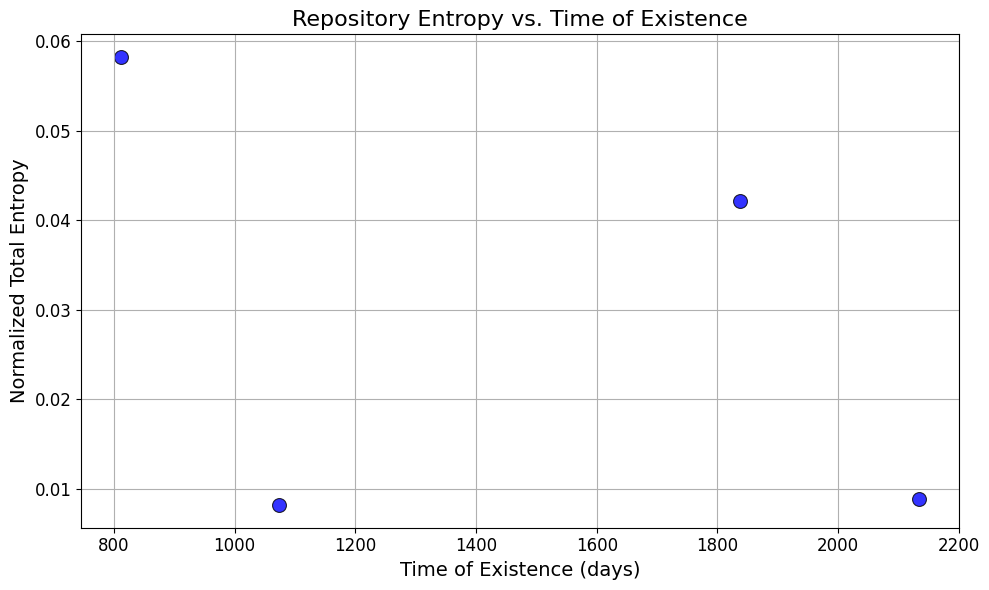

In [13]:
def main():
    df = pd.read_parquet(
        "../../../tests/data/examples/pubmed/pubmed_github_links.parquet"
    )

    # Filter where IsValid is True
    df_valid = df[df["IsValid"] == True]

    # Remove duplicate repository URLs
    df_valid = df_valid.drop_duplicates(subset="github_link")

    # Slice dataframe to allow for a testing subset
    repo_urls = df_valid["github_link"].iloc[120:124].tolist()

    # Using ProcessPoolExecutor for parallel processing with up to 16 workers
    with ProcessPoolExecutor(max_workers=16) as executor:
        entropies = []
        times = []

        # Submit tasks to executor and collect futures for result retrieval
        futures = {
            executor.submit(process_repository, repo_url): repo_url
            for repo_url in repo_urls
        }

        # Iterate through completed futures as they become available
        for future in as_completed(futures):
            repo_url = futures[future]
            try:
                # Retrieve result or raise exception
                normalized_total_entropy, time_of_existence = future.result()
                entropies.append(normalized_total_entropy)
                times.append(time_of_existence)
                print(
                    f"Repository: {repo_url}, Normalized Total Entropy: {normalized_total_entropy:.4f}, Time of Existence: {time_of_existence} days"
                )
            except Exception as e:
                print(f"Failed to process repository {repo_url}: {e}")

    # Plotting with Seaborn and Matplotlib to visualize results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=times, y=entropies, s=100, alpha=0.8, color="blue", edgecolor="black"
    )  # Customizing markers
    plt.title("Repository Entropy vs. Time of Existence", fontsize=16)
    plt.xlabel("Time of Existence (days)", fontsize=14)
    plt.ylabel("Normalized Total Entropy", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()